In [44]:
#compare the accuracy of each classification taxonomy

#still to-do:
    #code silva/silva_metaxa2

In [1]:
import re
import tempfile
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from qiime2 import Artifact
from qiime2.plugins.feature_classifier.methods import classify_consensus_vsearch
%matplotlib inline

In [2]:
def get_expected_results(path):
    """From a mockrobiota expected results fasta file, load sequences and their
    scientific name into a dataframe
        
    Parameters
    ----------
    path: path to the expected fasta file; str
    """
    
    sequences = []
    genera = []
    species_list = []

    with open(path) as expected: 
        for line in expected:
            #this is a header line; strip the > and newline character from it
            if line.startswith('>'):
                line = line.strip('>')
                line = line.strip('\n')
                #capture each word in the header into a list. The first two
                #words are the scientific name
                line_list = re.split(' |_', line)
                genus, species = line_list[:2]
                genera.append(genus)
                species_list.append(species)
            else:
                sequence = line.strip('\n')
                sequences.append(sequence)
    #we're left with 3 lists that we can combine into a dataframe
    results = pd.DataFrame(list(zip(sequences, genera, species_list)),
                           columns = ['sequence', 'genus', 'species'])
    
    return results

In [3]:
def get_sequences(path):

    """given the path of a 'representative sequences' quality controlled qiime2 artifact,
    return a dictionary with the hashes mapped to the sequences
    
    Parameters
    ----------
    path: the filepath of the .qza file exported from the rep_seqs artifact; str
    """
    
    with tempfile.TemporaryDirectory() as temp_dir:
        temp = Artifact.load(path)
        temp.export_data(temp_dir)
        
        hashes = []
        sequences = []
        with open(temp_dir + '/dna-sequences.fasta') as sequence_file:
            for line in sequence_file:
                if line.startswith('>'):
                    hashed_seq = line.lstrip('>')
                    hashed_seq = hashed_seq.rstrip('\n')
                    hashes.append(hashed_seq)
                else:
                    sequences.append(line.rstrip('\n'))
        results = dict(zip(hashes, sequences))
        
    return results

In [4]:
def get_assigned_taxonomy(classification_taxonomy, sequence_keys):
    """given a 'classification taxonomy' qiime2 artifact and a hash-sequence
    dict, return a dataframe of sequences plus their 7-level taxonomy.
    
    Parameters
    ----------
    classification_taxonomy: an artifact created by a qiime2 feature-classifer
                             method; FeatureData[Taxonomy] artifact
    
    sequence_keys: a dict of the hashes mapped to the full sequence; dict
    """
    
    hashes = []
    taxonomy_strings = []
    sequences = []
    kingdoms = []
    phyla = []
    classes = []
    orders = []
    families = []
    genera = []
    species_list = []
    hierarchy = ['k','p','c','o','f','g','s']
    #I'm not familiar enough with the API to extract the necessary data directly
    #from the artifact, so I export it to a temporary directory and grab the tsv
    #file from there.
    with tempfile.TemporaryDirectory() as temp_dir:
        classification_taxonomy.export_data(temp_dir)
        with open(temp_dir + '/taxonomy.tsv') as taxonomy_file:
            for line in taxonomy_file:
                #Feature ID is the header row
                if not line.startswith('Feature ID'):
                    #these are the columns, we capture them in a list. Since the
                    #final result is a dataframe, it might be more reasonable to
                    #import into a df, but I think dfs get pretty messy pretty
                    #quick when you start manipulating them. I'm also not sure
                    #about the relative speed of operations
                    hashed_sequence, taxonomy_string, consensus = line.split('\t')
                    hashes.append(hashed_sequence)
                    taxonomy_strings.append(taxonomy_string)
    #find the sequence associated with the hash and build a list of the actual
    #sequences
    for hashed_sequence in hashes:
        sequence = sequence_keys[hashed_sequence]
        sequences.append(sequence)
    #here i expand out each string to an excessive number of unassigneds to
    #ensure that there are at least 7 levels in every string, then capture the
    #first seven assignments into their respective level. Lots of formatting
    #adjustments.
    for taxonomy_string in taxonomy_strings:
        if taxonomy_string.startswith('Unassigned'):
            kingdom = 'Unassigned'
            phylum = 'Unassigned'
            taxon_class = 'Unassigned'
            order = 'Unassigned'
            family = 'Unassigned'
            genus = 'Unassigned'
            species = 'Unassigned'
        else:
            temp_string = taxonomy_string + '; Unassigned' * 6
            for rank in hierarchy:
                temp_string = temp_string.replace((rank + "__; "), "")
                temp_string = temp_string.replace((rank + "__"), "")
            temp_string = temp_string.replace('; ;', '; Unassigned;')
            kingdom, phylum, taxon_class, order, family, genus, species, _ = temp_string.split('; ', 7)
        kingdoms.append(kingdom)
        phyla.append(phylum)
        classes.append(taxon_class)
        orders.append(order)
        families.append(family)
        genera.append(genus)
        species_list.append(species)
    results = pd.DataFrame(list(zip(sequences, kingdoms, phyla, classes, orders,
                                    families, genera, species_list)),
                           columns =['sequence', 'kingdom', 'phylum', 'class',
                                     'order', 'family', 'genus', 'species'])
    
    return results

In [5]:
def calculate_match(observed_df, expected_df, level):
    """Compare two dataframes at the specified taxonomic level. Dataframes are
    matched by searching the observed sequence against the expected sequence.
    Returns a list of the number of true positives, false positives, false
    negatives, and sequences that could not be matched.

    Parameters
    ----------
    observed_df: dataframe with sequence and taxonomy columns, taken from a
                 classification-taxonomy artifact; df
    expected_df: dataframe with sequence and taxonomy columns, taken from a
                 mockrobiota expected-taxonomy file; df
    level: taxonomic level at which to compare dataframes; str or int.
    """
    #if the classfier correctly annotated the sequence, it's a true positive
    true_positives = 0
    #if the classifier couldn't assign it, we're calling it a false negative
    false_negatives = 0
    #if the classifier assigned it but got it wrong it is a false positive
    false_positives = 0
    #some observed sequences are not found in the expected taxonomy file. not
    #sure if this is due to the quality control steps or some other aspect. it
    #should not differ across references.
    unmatched=0

    #if an integer was passed as taxonomic level, convert it to the string
    if type(level) == int:
        levels = {1:'kingdom', 2:'phylum', 3:'class', 4:'order', 5:'family',
                  6:'genus', 7:'species'}
        level = levels[level]

    #iterate down the observed dataframe
    for row in observed_df.iterrows():
        #grab the value from the 'sequence' column of the observed df
        query_seq = row[1]['sequence']
        #search the expected dataframe for that sequence and grab that row
        seq_match = (expected_df[expected_df['sequence'].str.contains(query_seq)])
        seq_match = seq_match.reset_index(drop=True)
        #if there's no match, the df will be empty. if not, we have a match
        if not seq_match.empty:
            #grab the assigned taxonomic name at the specified level
            query = row[1][level]
            #grab the reference taxonomic name at the specified level
            expected = seq_match.loc[0][level]
            if query == 'Unassigned':
                false_negatives += 1
            elif query != expected:
                false_positives += 1
            elif query == expected:
                true_positives += 1
        #if the dataframe was empty the sequence couldn't be matched
        else:
            unmatched += 1
    #store the results in a list
    results = [true_positives, false_positives, false_negatives, unmatched]

    return results

In [6]:
working_dir = '/home/dylan/Documents/june_reset/'
list_of_mocks = [12,13,14,15,16,18,19,20,21,22,23]
references = ['greengenes', 'greengenes_metaxa2']

In [25]:
results_df = pd.DataFrame(columns = ['index', 'true_positives',
                                     'false_positives',
                                     'false_negatives', 'unmatched',
                                     'mock'])

#only genus and species are paired with sequences in the 
#expected-taxonomy files in mockrobiota, so that's what I'm using for
#now
for level in ['genus', 'species']:
    for mock_number in list_of_mocks:
        path = (working_dir + '/input/expected_results/mock_' +
                str(mock_number) + '_expected-sequences.fasta')
        #load the expected results into a dataframe
        expected_results = get_expected_results(path)
        #load the rep_seqs into variable
        seqs_path = (working_dir + '/input/rep_seqs/rep_seqs_mock_' +
                     str(mock_number) + '.qza')
        seq_artifact = Artifact.load(seqs_path)
        sequence_keys = get_sequences(seqs_path)
        stats = {}
        for reference in references:
            reference_read_path = (working_dir + 'input/' + reference +
                                   '_otus.qza')
            reference_reads = Artifact.load(reference_read_path)
            reference_taxonomy_path = (working_dir + 'input/' +
                                       reference + '_taxonomy.qza')
            reference_taxonomy = Artifact.load(reference_taxonomy_path)
            classification_taxonomy, = classify_consensus_vsearch(query = seq_artifact,
                                                                  reference_reads = reference_reads,
                                                                  reference_taxonomy = reference_taxonomy,
                                                                  threads = 4) 
            df = get_assigned_taxonomy(classification_taxonomy = classification_taxonomy,
                                       sequence_keys = sequence_keys)
            tp, fp, fn, u = calculate_match(df, expected_results,
                                            level)
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f_measure = 2 * ((precision * recall) / (precision +
                                                     recall))
            stats.update({reference:[tp, fp, fn, precision, recall, f_measure, u, level]})
        mock_df = pd.DataFrame.from_dict(stats, orient = 'index',
                                         columns = ['true_positives',
                                                    'false_positives',
                                                    'false_negatives',
                                                    'precision',
                                                    'recall',
                                                    'f-measure',
                                                    'unmatched',
                                                    'level'])
        mock_df = mock_df.reset_index()
        mock_df['mock'] = [mock_number]*2
        results_df = results_df.append(mock_df, ignore_index = True)
    #results_df = results_df.drop(columns='Unnamed: 0')
    results_df = results_df.rename(columns={'index':'reference'})
    


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-az_wyi0f/38223cb1-3415-4709-8685-480ec3f393cc/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-_6lp1zl2/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpccq_8uek

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-az_wyi0f/38223cb1-3415-4709-8685-480ec3f393cc/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-uqxiqw24/eaad73f6-4ae2-4c56-a85b-00b4380eedd1/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-l1onw8fj/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpcxx7229s

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-uqxiqw24/eaad73f6-4ae2-4c56-a85b-00b4380eedd1/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-_kdx96sh/543a1486-e437-4fb0-8938-e2fb43b8be20/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-01ov0v67/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpk_tijcjk

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-_kdx96sh/543a1486-e437-4fb0-8938-e2fb43b8be20/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-n_lq5iev/19c918f3-858a-4757-bf44-da40fe5f4798/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-g9c_m1ei/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpz5x72s9w

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-n_lq5iev/19c918f3-858a-4757-bf44-da40fe5f4798/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-z9ah8mhc/7d7b13a8-6a6a-4656-85dc-4cbe558fae9c/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-kufddk92/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmp13__xn8a

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-z9ah8mhc/7d7b13a8-6a6a-4656-85dc-4cbe558fae9c/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-hwwui_w7/0b460337-07cd-4c2d-8589-94b9f5baa0a5/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-8estrcpd/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpy3v0jp6e

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-hwwui_w7/0b460337-07cd-4c2d-8589-94b9f5baa0a5/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-vu_yneyd/d5aebdcc-01a0-4f47-b91d-38023903836f/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-qkltr3ec/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpeng9djf1

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-vu_yneyd/d5aebdcc-01a0-4f47-b91d-38023903836f/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-7qcevqj1/9a3da540-2b78-4daa-b6c2-97910f7fd939/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-k0btvcxo/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmp0hi0pmfp

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-7qcevqj1/9a3da540-2b78-4daa-b6c2-97910f7fd939/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-syb5pxov/317f444e-b7a3-45bf-b33a-522adbe921c5/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-fin8jifv/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpkvmpbdum

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-syb5pxov/317f444e-b7a3-45bf-b33a-522adbe921c5/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-dbf13vz4/acdf2b01-8f20-4ed6-af81-a46f8eca3109/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-dg165vjo/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpma9uyr4w

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-dbf13vz4/acdf2b01-8f20-4ed6-af81-a46f8eca3109/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-amau7v8s/60bcc3f3-d42b-445f-b35c-54caf9984aea/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-q_ya59l6/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpzdm0m_o5

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-amau7v8s/60bcc3f3-d42b-445f-b35c-54caf9984aea/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-xvr4tit4/38223cb1-3415-4709-8685-480ec3f393cc/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-8nfo_pro/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpth507jz_

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-xvr4tit4/38223cb1-3415-4709-8685-480ec3f393cc/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-xmfqjp17/eaad73f6-4ae2-4c56-a85b-00b4380eedd1/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-5r5uwldq/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmp9ol9pm03

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-xmfqjp17/eaad73f6-4ae2-4c56-a85b-00b4380eedd1/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-7d_x6x5l/543a1486-e437-4fb0-8938-e2fb43b8be20/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-o75ybju5/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmp_fvm0j55

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-7d_x6x5l/543a1486-e437-4fb0-8938-e2fb43b8be20/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-cw3d3da8/19c918f3-858a-4757-bf44-da40fe5f4798/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-uu3rly51/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpu22qnb0r

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-cw3d3da8/19c918f3-858a-4757-bf44-da40fe5f4798/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-g5bqty60/7d7b13a8-6a6a-4656-85dc-4cbe558fae9c/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-d8z132fs/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpqj0an27z

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-g5bqty60/7d7b13a8-6a6a-4656-85dc-4cbe558fae9c/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-xukeunmp/0b460337-07cd-4c2d-8589-94b9f5baa0a5/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-3ce1z60v/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpa_4pcsva

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-xukeunmp/0b460337-07cd-4c2d-8589-94b9f5baa0a5/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-0_gk3yk0/d5aebdcc-01a0-4f47-b91d-38023903836f/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-v7g7w_1m/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpt3mrkf1r

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-0_gk3yk0/d5aebdcc-01a0-4f47-b91d-38023903836f/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-hcamvup0/9a3da540-2b78-4daa-b6c2-97910f7fd939/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-6w1u_4ox/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpc83p8ta4

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-hcamvup0/9a3da540-2b78-4daa-b6c2-97910f7fd939/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-xmt63yjh/317f444e-b7a3-45bf-b33a-522adbe921c5/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-97zbo1n4/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpndkd9ezb

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-xmt63yjh/317f444e-b7a3-45bf-b33a-522adbe921c5/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-_rzz7a2c/acdf2b01-8f20-4ed6-af81-a46f8eca3109/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-hofrip20/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpoxmuc6nc

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-_rzz7a2c/acdf2b01-8f20-4ed6-af81-a46f8eca3109/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-4m3tmgoh/60bcc3f3-d42b-445f-b35c-54caf9984aea/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-a_szof06/7c8c997f-3906-4d36-9355-e9d4c5214299/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmpu_vpahe3

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-4m3tmgoh/60bcc3f3-d42b-445f-b35c-54caf9984aea/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_

/home/dylan/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [27]:
a = results_df
a

,f-measure,false_negatives,false_positives,reference,level,mock,precision,recall,reference,true_positives,unmatched
0,0.790698,5,4,NaN,genus,12,0.809524,0.772727,greengenes,17,47
1,0.790698,5,4,NaN,genus,12,0.809524,0.772727,greengenes_metaxa2,17,47
2,0.952381,3,0,NaN,genus,13,1.000000,0.909091,greengenes,30,97
3,0.952381,3,0,NaN,genus,13,1.000000,0.909091,greengenes_metaxa2,30,97
4,0.953846,3,0,NaN,genus,14,1.000000,0.911765,greengenes,31,122
5,0.953846,3,0,NaN,genus,14,1.000000,0.911765,greengenes_metaxa2,31,122
6,0.953846,3,0,NaN,genus,15,1.000000,0.911765,greengenes,31,122
7,0.953846,3,0,NaN,genus,15,1.000000,0.911765,greengenes_metaxa2,31,122
8,0.747253,22,1,NaN,genus,16,0.971429,0.607143,greengenes,34,36
9,0.747253,22,1,NaN,genus,16,0.971429,0.607143,greengenes_metaxa2,34,36


In [30]:
#results_df = df.set_index('mock')
#results_df = results_df.drop(columns='Unnamed: 0')
results_df.drop(['reference'], axis = 1)
lst = ['greengenes','greengenes_metaxa2']*22
results_df['reference'] = lst
results_df.to_csv('compare_accuracy.csv')

In [10]:
results_a = pd.read_csv('compare_accuracy.csv', index_col = 0)
lst = ['greengenes','greengenes_metaxa2']*22
results_a['reference'] = lst
results_a

,f-measure,false_negatives,false_positives,reference,level,mock,precision,recall,reference.1,true_positives,unmatched
0,0.790698,5,4,greengenes,genus,12,0.809524,0.772727,greengenes,17,47
1,0.790698,5,4,greengenes_metaxa2,genus,12,0.809524,0.772727,greengenes_metaxa2,17,47
2,0.952381,3,0,greengenes,genus,13,1.000000,0.909091,greengenes,30,97
3,0.952381,3,0,greengenes_metaxa2,genus,13,1.000000,0.909091,greengenes_metaxa2,30,97
4,0.953846,3,0,greengenes,genus,14,1.000000,0.911765,greengenes,31,122
5,0.953846,3,0,greengenes_metaxa2,genus,14,1.000000,0.911765,greengenes_metaxa2,31,122
6,0.953846,3,0,greengenes,genus,15,1.000000,0.911765,greengenes,31,122
7,0.953846,3,0,greengenes_metaxa2,genus,15,1.000000,0.911765,greengenes_metaxa2,31,122
8,0.747253,22,1,greengenes,genus,16,0.971429,0.607143,greengenes,34,36
9,0.747253,22,1,greengenes_metaxa2,genus,16,0.971429,0.607143,greengenes_metaxa2,34,36


In [12]:
b = results_a.loc[:,['f-measure', 'level', 'mock', 'reference']]
b

,f-measure,level,mock,reference
0,0.790698,genus,12,greengenes
1,0.790698,genus,12,greengenes_metaxa2
2,0.952381,genus,13,greengenes
3,0.952381,genus,13,greengenes_metaxa2
4,0.953846,genus,14,greengenes
5,0.953846,genus,14,greengenes_metaxa2
6,0.953846,genus,15,greengenes
7,0.953846,genus,15,greengenes_metaxa2
8,0.747253,genus,16,greengenes
9,0.747253,genus,16,greengenes_metaxa2


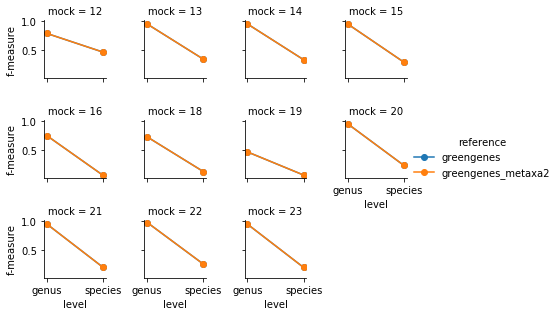

In [21]:
grid = sns.FacetGrid(b, col='mock', hue = 'reference', col_wrap = 4, height = 1.5, legend_out = True)
grid.map(plt.plot, "level", "f-measure", marker = "o").add_legend()
plt.show()

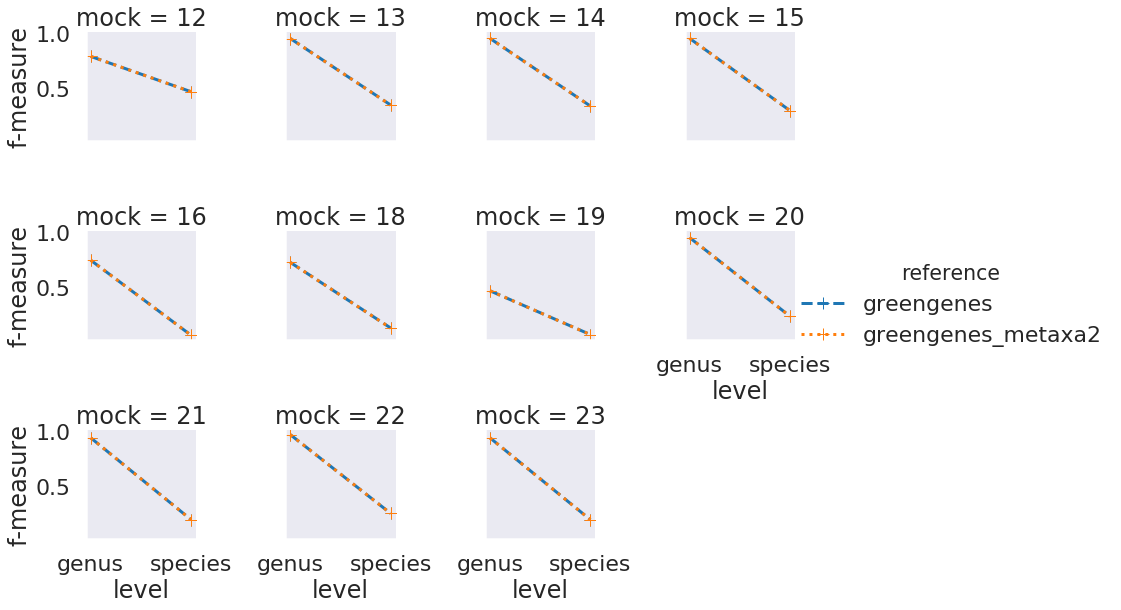

In [22]:
sns.set_style("dark")
sns.set_context("poster")
d = {"ls" : ["dashed","dotted"]}
grid = sns.FacetGrid(b, col='mock', hue = 'reference', col_wrap = 4, height = 3, hue_kws=d)
g = grid.map(plt.plot, "level", "f-measure", marker = "+").add_legend()
plt.show()